<a href="https://colab.research.google.com/github/jyothsnashaji/Image-Reconstruction/blob/master/SART_%2B_CNN_PART_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
!pip install pydicom
!pip install gputil
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install psutil
!pip install humanize

     |████████████████████████████████| 35.3MB 90kB/s 
  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=cb3c6baa881b151e6d9b14b08b6a4d42cd8331c96fde630b16a781e4aad34103
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [0]:
from google.colab import drive
drive.flush_and_unmount()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Imports

In [1]:
#@title
import pydicom
import numpy as np
from skimage import morphology
from scipy import ndimage
import os
import matplotlib.pyplot as plt
from skimage.transform import radon, rescale,iradon_sart,iradon
from tensorflow import keras
import tensorflow as tf
from keras import backend
import GPUtil 
import sys,humanize,psutil
import math

path='/content/drive/My Drive/Major Project'


Using TensorFlow backend.


In [2]:

# Import packages

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))
    
# Execute function
mem_report()

CPU RAM Free: 8.8 GB
GPU 0 ... Mem Free: 757MB / 16280MB | Utilization  95%


Windowing and Noise Removal Functions




In [0]:
#@title
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

def remove_noise(brain_image, display=False):
    #medical_image = pydicom.read_file(file_path,force=True)
    #medical_image.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian

    #image = medical_image.pixel_array
    
    #hu_image = transform_to_hu(medical_image, image)
    #brain_image = window_image(hu_image, window_lower, window_upper)
    # morphology.dilation creates a segmentation of the image
    # If one pixel is between the origin and the edge of a square of size
    # 5x5, the pixel belongs to the same class
    
    # We can instead use a circule using: morphology.disk(2)
    # In this case the pixel belongs to the same class if it's between the origin
    # and the radius
    
    segmentation = morphology.dilation(brain_image, np.ones((4, 4)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    # The size of label_count is the number of classes/segmentations found
    
    # We don't use the first class since it's the background
    label_count[0] = 0
    
    # We create a mask with the class with more pixels
    # In this case should be the brain
    mask = labels == label_count.argmax()
    
    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((4, 4)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((2, 2)))
    
    # Since the the pixels in the mask are zero's and one's
    # We can multiple the original image to only keep the brain region
    masked_image = mask * brain_image

    if display:
        plt.figure(figsize=(30, 5))
        plt.subplot(141)
        plt.imshow(brain_image,cmap=plt.cm.Greys_r)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(mask,cmap=plt.cm.Greys_r)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(masked_image,cmap=plt.cm.Greys_r)
        plt.title('Final Image')
        plt.axis('off')
    
    return masked_image

Saving Preprocessed images to folder

In [0]:
#@title


window_center= 457
window_width= 3000

folder = os.fsencode(path+'/FullDicom')
for file in os.listdir(folder):
  filename= os.fsdecode(file)
  print(filename)
  medical_image = pydicom.read_file(path+'/FullDicom/'+filename,force=True)
  medical_image.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
  image = medical_image.pixel_array
  hu_image = transform_to_hu(medical_image,image)
  brain_image = window_image(hu_image, window_center, window_width)
  # bone_image = window_image(hu_image, 400, 1000)
  noise_removed=remove_noise(brain_image, display=False)
  # fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16, 9))
  # fig.suptitle(filename)
  # ax1.set_title('Original')
  # ax1.imshow(hu_image, cmap=plt.cm.Greys_r)
  # ax2.set_title('Preprocessed')
  # ax2.imshow(brain_image, cmap=plt.cm.Greys_r)
  # ax3.set_title('Noise Removed')
  # ax3.imshow(noise_removed, cmap=plt.cm.Greys_r)
  print(np.min(image),np.max(image))
  #np.save(path+'/Preprocessed/'+filename[:-3]+'npy',image)
  #image=np.load(path+'/Preprocessed/'+filename[:-3]+'npy')
  #ax4.imshow(image, cmap=plt.cm.Greys_r)
  

  


Taking Sparse Projections and reconstructing image

In [0]:
#@title

downfactor= 100# # Number of angles taken
sart_iterations=5 # Number of iterations of SART
window_center=457
window_width=3000
folder = os.fsencode(path+'/FullDicom/')

for file in os.listdir(folder):
  filename = os.fsdecode(file)

  ds=pydicom.dcmread(path+'/FullDicom/'+filename,force=True)
  ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
  image=ds.pixel_array
  print(filename)
  theta = np.linspace(0., 180., downfactor, endpoint=False)
  sinogram = radon(image, theta=theta,preserve_range=True)
  sart=iradon_sart(sinogram, theta=theta)
  for x in range(1,sart_iterations):
    sart = iradon_sart(sinogram, theta=theta,image=sart)
  # hu_image=transform_to_hu(ds,sart)
  # brain_image = window_image(hu_image, window_center, window_width)
  # noise_removed=remove_noise(brain_image)
  mse_custom(image,sart)
  #plt.imshow(sart,cmap=plt.cm.Greys_r)
  #sart[sart<0]=0
  #np.save(path+'/SparseRecon/'+filename[:-3]+'npy',sart)
  
  
  
  



0.DCM
MSE: 593.8164846932474
1.DCM
MSE: 606.4157627607655
2.DCM
MSE: 593.39777716362
3.DCM
MSE: 575.4904864021325
4.DCM
MSE: 550.1871699535932
5.DCM
MSE: 533.9877563089847
6.DCM
MSE: 546.5519548418896
7.DCM
MSE: 429.53976742946446
8.DCM
MSE: 441.05349849665737
9.DCM
MSE: 424.07206129971246
10.DCM
MSE: 417.10780151505855
11.DCM
MSE: 417.39266172592085
12.DCM
MSE: 402.30063656524186
13.DCM
MSE: 398.90655081337684
14.DCM
MSE: 389.7630515180859
15.DCM
MSE: 372.313572307763
16.DCM
MSE: 370.2367130950151
17.DCM
MSE: 353.7092255880465
18.DCM
MSE: 349.985488153233
19.DCM
MSE: 347.1510556266939
20.DCM
MSE: 372.4230016219198
21.DCM
MSE: 361.30846665318546
22.DCM
MSE: 384.588222282315
23.DCM


KeyboardInterrupt: ignored

Image Generator

In [0]:
#@title  { form-width: "5px" }

class ImageGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, data_dir, batch_size = 32, x_dim=(512,512,1), y_dim=(512,512,1), shuffle=True):
        self.list_IDs = list_IDs
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs)/self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_IDs = [self.list_IDs[k] for k in batch_indexes]
        
        X, Y = self.__batch_data_generation(batch_IDs)
        
        return X,Y
    
    def __batch_data_generation(self, batch_IDs):
        X = np.empty((self.batch_size, *self.x_dim)) #* is used to unpack the self.dim tuple
        Y = np.empty((self.batch_size, *self.y_dim))
        
        for i, ID in enumerate(batch_IDs):
            X[i,:], Y[i,:] = self.load_mat(ID)
            
        return X,Y
    
    def load_mat(self, ID):
        filename =  str(ID)
        input=np.load(self.data_dir+'/SparseRecon/'+filename+'.npy')
        target=np.load(self.data_dir+'/Preprocessed/'+filename + '.npy')
        # fig,(ax1,ax2)=plt.subplots(1,2)
        # ax1.imshow(np.squeeze(input), cmap=plt.cm.Greys_r)        
        # ax2.imshow(np.squeeze(target), cmap=plt.cm.Greys_r)        

        input = np.reshape(input, self.x_dim)
        target = np.reshape(target, self.y_dim)
        # print(np.min(input),np.max(input))
        # print(np.min(target),np.max(target))
        # with tf.compat.v1.Session() as sess:
        #    print(str(ssim_loss(target,input).eval()))

        # error = target - input
        # print(f"{np.sqrt(np.mean(error**2)):.3g}")
        return input,target

if __name__ == '__main__':
   
    generator = ImageGenerator(list(np.arange(1, 11)), path)
    generator.load_mat(5)

U-Net

In [15]:
#@title  { form-width: "1px" }

def UNet(input_size, pretrained_weights = None):
    inputs = keras.Input(shape = input_size)
    
    #level 1
    conv64_1 = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(inputs)
    conv64_1_BN = keras.layers.BatchNormalization()(conv64_1)
    conv64_2 = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(conv64_1_BN)
    conv64_2_BN = keras.layers.BatchNormalization()(conv64_2)
    conv64_3 = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(conv64_2_BN)
    conv64_3_BN = keras.layers.BatchNormalization()(conv64_3)
    
    #downsampling to level 2
    conv64_3_pool = keras.layers.MaxPool2D([2,2], padding = 'valid')(conv64_3_BN)
    conv64_3_pool=keras.layers.Dropout(0.25)(conv64_3_pool)

    conv128_1 = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation = 'relu')(conv64_3_pool)
    conv128_1_BN = keras.layers.BatchNormalization()(conv128_1)
    conv128_2 = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation = 'relu')(conv128_1_BN)
    conv128_2_BN = keras.layers.BatchNormalization()(conv128_2)
    
    #downsampling to level 3
    conv128_2_pool = keras.layers.MaxPool2D([2,2], padding = 'valid')(conv128_2_BN)
    conv128_2_pool=keras.layers.Dropout(0.5)(conv128_2_pool)

    conv256_1 = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation = 'relu')(conv128_2_pool)
    conv256_1_BN = keras.layers.BatchNormalization()(conv256_1)
    conv256_2 = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation = 'relu')(conv256_1_BN)
    conv256_2_BN = keras.layers.BatchNormalization()(conv256_2)
    
    #downsampling to level 4
    conv256_2_pool = keras.layers.MaxPool2D([2,2], padding = 'valid')(conv256_2_BN)
    conv256_2_pool=keras.layers.Dropout(0.5)(conv256_2_pool)

    conv512_1 = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation = 'relu')(conv256_2_pool)
    conv512_1_BN = keras.layers.BatchNormalization()(conv512_1)
    conv512_2 = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation = 'relu')(conv512_1_BN)
    conv512_2_BN = keras.layers.BatchNormalization()(conv512_2)
    
    #downsampling to level 5
    conv512_2_pool = keras.layers.MaxPool2D([2,2], padding = 'valid')(conv512_2_BN)
    conv512_2_pool=keras.layers.Dropout(0.5)(conv512_2_pool)

    conv1024_1 = keras.layers.Conv2D(1024, [3,3], [1,1], 'same', activation = 'relu')(conv512_2_pool)
    conv1024_1_BN = keras.layers.BatchNormalization()(conv1024_1)
    conv1024_2 = keras.layers.Conv2D(1024, [3,3], [1,1], 'same', activation = 'relu')(conv1024_1_BN)
    conv1024_2_BN = keras.layers.BatchNormalization()(conv1024_2)
    
    #upsampling to level 4
    level4_ini = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation='relu')(keras.layers.UpSampling2D((2,2))(conv1024_2_BN))
    level4_ini_concat = keras.layers.concatenate([conv512_2_BN, level4_ini], axis = -1)
    level4_ini_concat=keras.layers.Dropout(0.5)(level4_ini_concat)
    
    conv512_1_up = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation = 'relu')(level4_ini_concat)
    conv512_1_BN_up = keras.layers.BatchNormalization()(conv512_1_up)
    conv512_2_up = keras.layers.Conv2D(512, [3,3], [1,1], 'same', activation = 'relu')(conv512_1_BN_up)
    conv512_2_BN_up = keras.layers.BatchNormalization()(conv512_2_up)
    
    #upsampling to level 3
    level3_ini = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation='relu')(keras.layers.UpSampling2D((2,2))(conv512_2_BN_up))
    level3_ini_concat = keras.layers.concatenate([conv256_2_BN, level3_ini], axis = -1)
    level3_ini_concat=keras.layers.Dropout(0.5)(level3_ini_concat)

    
    conv256_1_up = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation = 'relu')(level3_ini_concat)
    conv256_1_BN_up = keras.layers.BatchNormalization()(conv256_1_up)
    conv256_2_up = keras.layers.Conv2D(256, [3,3], [1,1], 'same', activation = 'relu')(conv256_1_BN_up)
    conv256_2_BN_up = keras.layers.BatchNormalization()(conv256_2_up)
    
    #upsampling to level 2
    level2_ini = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation='relu')(keras.layers.UpSampling2D((2,2))(conv256_2_BN_up))
    level2_ini_concat = keras.layers.concatenate([conv128_2_BN, level2_ini], axis = -1)
    level2_ini_concat=keras.layers.Dropout(0.5)(level2_ini_concat)

    
    conv128_1_up = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation = 'relu')(level2_ini_concat)
    conv128_1_BN_up = keras.layers.BatchNormalization()(conv128_1_up)
    conv128_2_up = keras.layers.Conv2D(128, [3,3], [1,1], 'same', activation = 'relu')(conv128_1_BN_up)
    conv128_2_BN_up = keras.layers.BatchNormalization()(conv128_2_up)
    
    #upsampling to level 1
    level1_ini = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation='relu')(keras.layers.UpSampling2D((2,2))(conv128_2_BN_up))
    level1_ini_concat = keras.layers.concatenate([conv64_3_BN, level1_ini], axis = -1)
    level1_ini_concat=keras.layers.Dropout(0.5)(level1_ini_concat)

    
    conv64_1_up = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(level1_ini_concat)
    conv64_1_BN_up = keras.layers.BatchNormalization()(conv64_1_up)
    conv64_2_up = keras.layers.Conv2D(64, [3,3], [1,1], 'same', activation = 'relu')(conv64_1_BN_up)
    conv64_2_BN_up = keras.layers.BatchNormalization()(conv64_2_up)
    conv1_up = keras.layers.Conv2D(1, [1,1], [1,1], 'same')(conv64_2_BN_up)
    outputs = keras.layers.add([inputs, conv1_up])
    
    
    ###################################################################################
    model = keras.models.Model(inputs = inputs, outputs = outputs)
    if pretrained_weights:
        model.load_weights(pretrained_weights)
    
    return model

if __name__ == '__main__':
    model = UNet((512,512,1))
    model.summary()
    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

Plots

In [0]:
#@title
from matplotlib import pyplot as plt
from IPython.display import clear_output
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        #self.acc = []
        #self.val_acc = []
        self.ssim=[]
        self.psnr=[]
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.ssim.append(logs.get('ssim_loss'))
        self.psnr.append(logs.get('psnr'))
        #self.acc.append(logs.get('acc'))
        #self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(16,8), sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.set_ylabel('MSE')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        
        ax2.plot(self.x, self.ssim, label="ssim")
        ax2.set_ylabel('SSIM')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        
        ax3.plot(self.x, self.psnr, label="psnr")
        ax3.set_ylabel('PSNR')
        ax3.set_xlabel('Epoch')
        ax3.legend()
    
        plt.savefig(path+'/resUnet.png')
        plt.show()

        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))


GPUs = GPUtil.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]        
plot = PlotLearning()

Metrics for Evaluation

In [0]:
#@title

 
# Structural Similarity Index
def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 4095))

# Peak Signal To Noise Ratio
def psnr(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred,4095))


In [0]:
def psnr_custom(ori,pred):
  MAX=4095
  img1 = ori.astype(np.float64) / MAX
  img2 = pred.astype(np.float64) / MAX
  mse1 = np.mean((img1 - img2) ** 2)
  if mse1 == 0:
    print("Same Image")
  print("PSNR ",10 * math.log10(1. / mse1))


In [0]:
def mse_custom(imageA,imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	print("MSE: "+ str(err) ) 

Training

In [0]:
train_IDs = list(np.arange(194, 479))
val_IDs = list(np.arange(0, 193))
train_generator = ImageGenerator(train_IDs, path, batch_size = 2)
val_generator = ImageGenerator(val_IDs, path, batch_size = 2)

model = MultiResUnet(512,512,1)
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [ssim_loss,psnr])

In [0]:


history= model.fit(train_generator, epochs = 150, validation_data = val_generator,steps_per_epoch=20,verbose=1,
                             use_multiprocessing=True,
                    workers = 6, callbacks = [plot])
model.save(path+"/resunet.h5")

Epoch 1/150


*Load* Model from Disk



In [0]:
from tensorflow.keras.models import load_model
dependencies={
    'ssim_loss':ssim_loss,
    'psnr':psnr
}
# load model
model = load_model(path+'/adam+mse.h5',custom_objects=dependencies)

Testing

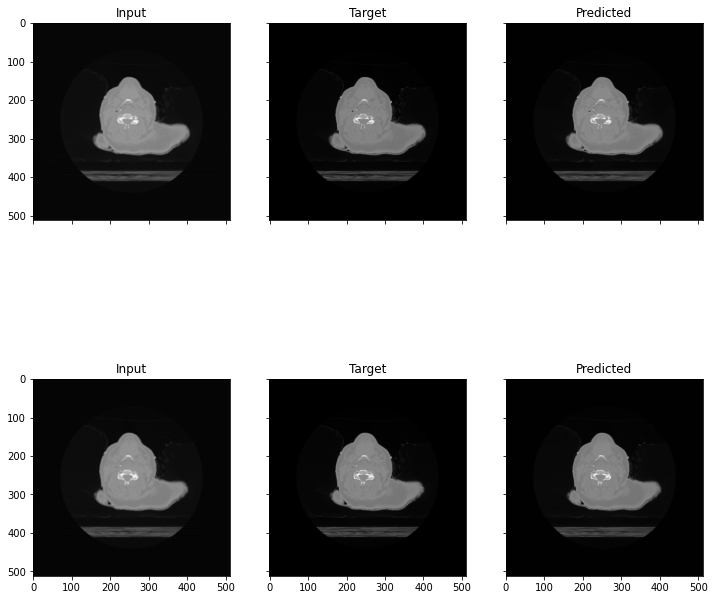

In [0]:
#@title
import matplotlib.pyplot as plt

n=2
m=20
gen=ImageGenerator(np.arange(m,n+m),path, batch_size = 1)
pre=model.predict(gen)
#print(np.shape(pre))
fig,ax=plt.subplots(n,3,figsize=(12,12),sharex=True,sharey=True)

i=m
while(i<n+m):
  input_, target=gen.load_mat(i)  
  ax[i-m][0].imshow(np.squeeze(input_), cmap=plt.cm.Greys_r)
  ax[i-m][0].set_title('Input')

  ax[i-m][1].imshow(np.squeeze(target), cmap=plt.cm.Greys_r)
  ax[i-m][1].set_title('Target')

  ax[i-m][2].imshow(np.squeeze(pre[i-m]), cmap=plt.cm.Greys_r)
  ax[i-m][2].set_title('Predicted')

  i=i+1

#plt.savefig(path+'FBP/'+'no.png')
plt.show()

In [0]:
print(model.metrics_names)
p=np.random.randint(0,479,10)
for p_ in p:
  gen=ImageGenerator(np.arange(p_,p_+1),path, batch_size = 1)
  print(p_,model.evaluate(gen,verbose=0 ))


['loss', 'ssim_loss', 'psnr']
412 [63.83295822143555, 0.9983349442481995, 54.19462203979492]
258 [45.641605377197266, 0.9981250166893005, 55.65146255493164]
133 [58.11940383911133, 0.9987290501594543, 54.60186004638672]
324 [57.21125793457031, 0.9979455471038818, 54.670257568359375]
370 [128.88140869140625, 0.9976975917816162, 51.14316940307617]
34 [51.95606231689453, 0.998450517654419, 55.088706970214844]
12 [165.085205078125, 0.9938677549362183, 50.0679931640625]
180 [45.1189079284668, 0.9990657567977905, 55.70148468017578]
58 [42.816932678222656, 0.998672366142273, 55.928916931152344]
446 [88.27802276611328, 0.9968377351760864, 52.78654479980469]


In [0]:
n=12
gen=ImageGenerator(np.arange(n,n+1),path, batch_size = 1)
pre=model.predict(gen)
_,target=gen.load_mat(n)
psnr_custom(target,pre[0])
error = target - pre[0]
print(f"{np.sqrt(np.mean(error**2)):.3g}")

mse_custom(target,pre[0])


PSNR  50.15563120755133
12.7
MSE: 161.78739839494474


Saving to DICOM

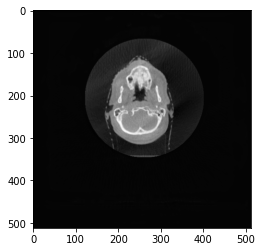

In [0]:
import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids
i=20

gen=ImageGenerator(np.arange(i,i+1),path, batch_size = 1)
pre=model.predict(gen)
image2d=pre[0]
image2d=np.reshape(image2d,(512,512))

plt.imshow(image2d,cmap=plt.cm.Greys_r)
original = pydicom.read_file(path+'FullDicom/'+str(i)+'.DCM',force=True)
original.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
original.PhotometricInterpretation = "MONOCHROME2"
original.PixelRepresentation = 1
original.PixelData = image2d.astype(np.uint16).tobytes()

#ds.PixelData = image2d.tobytes()

original.save_as(path+'/Predicted/'+ str(i) + '.DCM')

Testing Saved DICOM


In [0]:
import math
i=20

medical_image = pydicom.read_file(path+'Predicted/'+str(i)+'.DCM',force=True)
medical_image.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
pred = medical_image.pixel_array
pred=np.reshape(pred,(512,512,1))

gen=ImageGenerator(np.arange(i,i+1),path, batch_size = 1)
x,ori=gen.load_mat(i)
pre=model.predict(gen)
image2d=pre[0]

img1 = ori.astype(np.float64) / 255.
img2 = pred.astype(np.float64) / 255.
img3 = image2d.astype(np.float64) / 255.
mse1 = np.mean((img1 - img2) ** 2)
mse2 = np.mean((img1 - img3) ** 2)
if mse1 == 0:
  print("Same Image")
print("psnr pred")
print(10 * math.log10(1. / mse1))
if mse2 == 0:
  print("Same Image")
print("psnr original")
print(10 * math.log10(1. / mse2))


image2d=np.reshape(image2d,(512,512,1))

with tf.compat.v1.Session() as sess:
    print(str(psnr(ori,image2d).eval()))
    print(str(psnr(ori,pred).eval()))
    print(str(psnr(ori,x).eval()))

psnr pred
21.763637353627367
psnr original
21.931649963119703
21.93165
-11.451794
17.847105
